In [156]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import json

# Load dataset from JSON file
with open('dataset.json', 'r') as f:
    dataset = json.load(f)

# Split dataset into training, validation, and testing sets
split_index_train = int(len(dataset) * 0.8)
split_index_val = int(len(dataset) * 0.9)

train_data = dataset[:split_index_train]
val_data = dataset[split_index_train:split_index_val]
test_data = dataset[split_index_val:]

# Extract raw code and binary vulnerability matrix from the dataset
X_raw_train = [sample['raw_code'] for sample in train_data]
X_raw_val = [sample['raw_code'] for sample in val_data]
X_raw_test = [sample['raw_code'] for sample in test_data]

y_vector_train = [sample['binary_vulnerability_vector'] for sample in train_data]
y_vector_val = [sample['binary_vulnerability_vector'] for sample in val_data]
y_vector_test = [sample['binary_vulnerability_vector'] for sample in test_data]

# Tokenize and preprocess the raw code
def tokenize_and_preprocess(raw_code_list, tokenizer=None, vocab_size=10000, max_sequence_length=1000):
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
        tokenizer.fit_on_texts(raw_code_list)
    sequences = tokenizer.texts_to_sequences(raw_code_list)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    return padded_sequences, tokenizer

X_tokenized_train, tokenizer = tokenize_and_preprocess(X_raw_train)
X_tokenized_val, _ = tokenize_and_preprocess(X_raw_val, tokenizer)
X_tokenized_test, _ = tokenize_and_preprocess(X_raw_test, tokenizer)

# Define constants
VOCAB_SIZE = tokenizer.num_words
EMBEDDING_DIM = 128
input_shape = X_tokenized_train.shape[1]
output_shape = len(y_vector_train[0])

# Adjusting the model architecture by adding more layers and units
# Adjusting the model architecture by reducing the number of layers
def create_model(input_shape, vocab_size, embedding_dim, output_shape):
    model = models.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_shape),
        layers.GlobalMaxPooling1D(),
        layers.Dense(output_shape, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and compile the model
model = create_model(input_shape, VOCAB_SIZE, EMBEDDING_DIM, output_shape)
model.summary()

# Train the model
history = model.fit(X_tokenized_train, np.array(y_vector_train), 
                    epochs=20, 
                    batch_size=64,  
                    validation_data=(X_tokenized_val, np.array(y_vector_val)),
                    callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_tokenized_test, np.array(y_vector_test))
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Save the model
model.save('vulnerability_detection_model.h5')


Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_70 (Embedding)    (None, 1000, 128)         1280000   
                                                                 
 global_max_pooling1d_63 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_144 (Dense)           (None, 5)                 645       
                                                                 
Total params: 1280645 (4.89 MB)
Trainable params: 1280645 (4.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
25/25 [==============================] - 2s 56ms/step - loss: 0.6417 - accuracy: 0.3419 - val_loss: 0.5780 - val_accuracy: 0.3650
Epoch 2/20
25/25 [==============================] - 1s 49ms/step - loss:

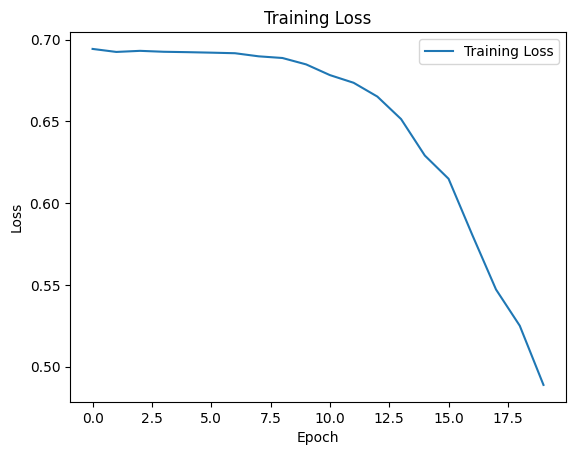

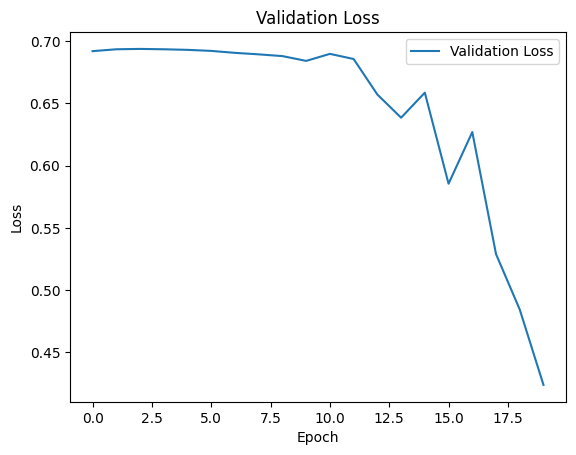

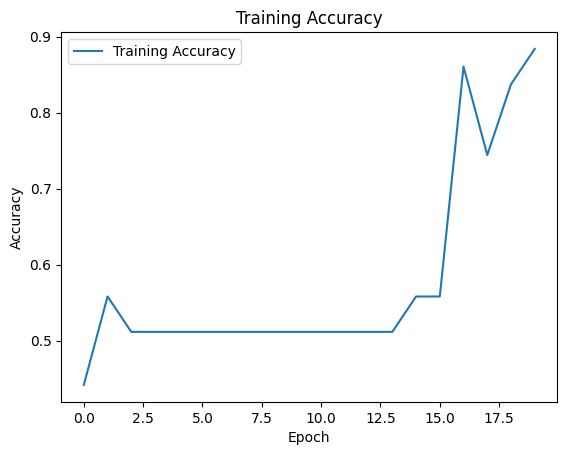

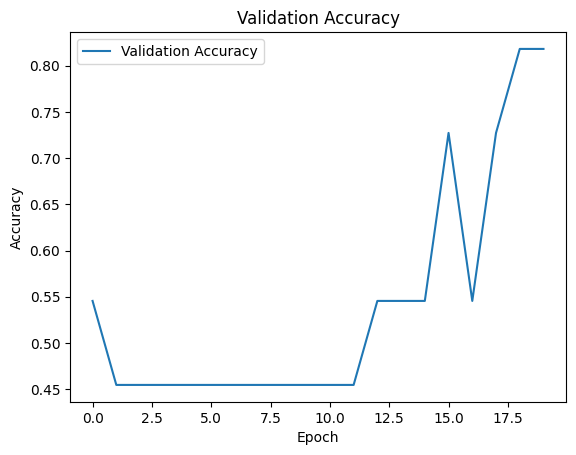

In [197]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Check if validation data is provided
if 'val_loss' in history.history:
    # Plot validation loss
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Check if validation data is provided
if 'val_accuracy' in history.history:
    # Plot validation accuracy
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


Step 1
Step 2
Step 3
Step 5
Model: "GuardianAI"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 code_input (InputLayer)     [(None, 250)]             0         
                                                                 
 embedding_92 (Embedding)    (None, 250, 64)           640000    
                                                                 
 bidirectional_25 (Bidirect  (None, 128)               66048     
 ional)                                                          
                                                                 
 dense_167 (Dense)           (None, 24)                3096      
                                                                 
 output (Dense)              (None, 1)                 25        
                                                                 
Total params: 709169 (2.71 MB)
Trainable params: 709169 (2.71 MB)
Non-trainable params: 0 (0.0

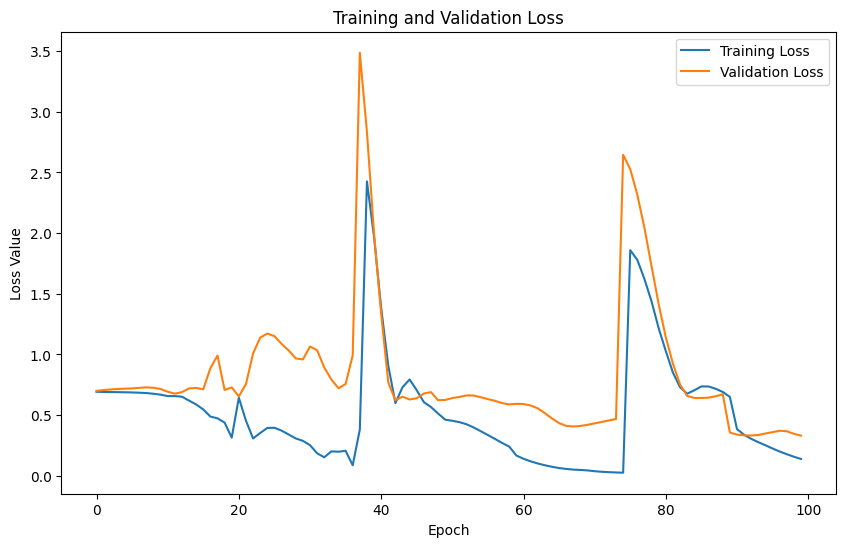

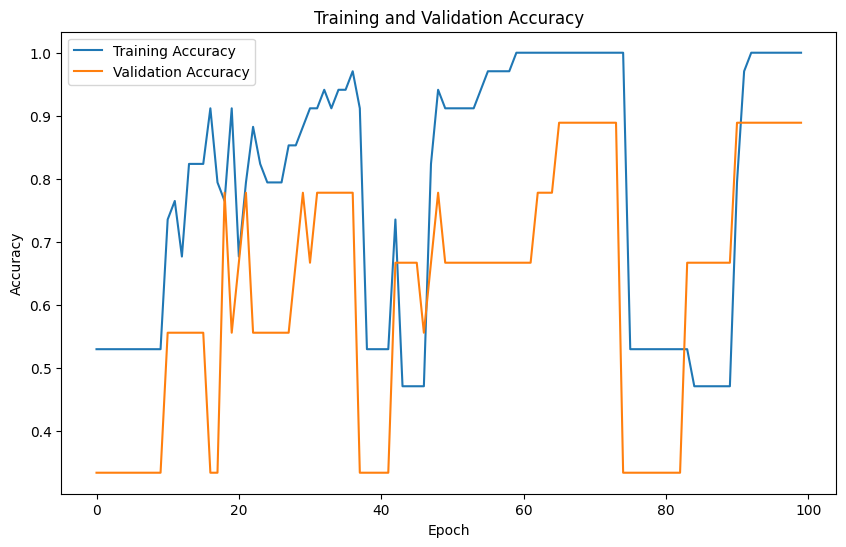

INFO:tensorflow:Assets written to: AI_Hackathon\assets


INFO:tensorflow:Assets written to: AI_Hackathon\assets


In [204]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv('data.csv')  # Update 'data.csv' with your CSV file name
code_snippets = data['code_snippet'].values
labels = data['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(code_snippets, labels, test_size=0.2, random_state=42)

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

# Fit the tokenizer on the training code snippets
tokenizer.fit_on_texts(X_train)

# Convert training code snippets to sequences of integers
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure uniform length
max_sequence_length = 250  # Maximum length after padding sequences
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_sequence_length, padding='post')
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_sequence_length, padding='post')

# Convert to numpy arrays
X_train_np = np.array(padded_sequences_train)
X_test_np = np.array(padded_sequences_test)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

# Input for code snippets
code_input = Input(shape=(max_sequence_length,), name='code_input')

# Embedding for code input
code_embedding = Embedding(input_dim=10000, output_dim=64)(code_input)
code_lstm = Bidirectional(LSTM(64))(code_embedding)

# Classification layer
classification_output = Dense(24, activation='relu')(code_lstm)
classification_output = Dense(1, activation='sigmoid', name='output')(classification_output)

# Create the model
model = Model(inputs=code_input, outputs=classification_output, name='GuardianAI')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
history = model.fit(
    X_train_np,
    y_train_np,
    batch_size=32,
    epochs=100,
    validation_split=0.2
)

# Evaluate the model using the testing data
test_loss, test_accuracy = model.evaluate(X_test_np, y_test_np)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the model
model.save('AI_Hackathon')


In [199]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json

# Load existing model if available
try:
    model = tf.keras.models.load_model('AI Hackathon')
    print("Loaded pre-trained model")
except:
    # If no pre-trained model available, create a new one
    print("No pre-trained model found, creating a new model")
    model = create_model(input_shape, VOCAB_SIZE, EMBEDDING_DIM, output_shape)

# Continuously collect and process new data
while True:
    # Load new data from JSON file
    with open('newdatas.json', 'r') as f:
        new_data = json.load(f)
    
    # Preprocess new data
    X_raw_new = [sample['raw_code'] for sample in new_data]
    y_vector_new = [sample['binary_vulnerability_vector'] for sample in new_data]
    X_tokenized_new, _ = tokenize_and_preprocess(X_raw_new, tokenizer)
    
    # Train model incrementally with new data
    model.fit(X_tokenized_new, np.array(y_vector_new), epochs=1, batch_size=64)
    
    # Periodically evaluate model performance

    model.save('AI Hackathon')


Loaded pre-trained model


FileNotFoundError: [Errno 2] No such file or directory: 'newdatas.json'

In [135]:
import json
import random

# Define a function to generate vulnerable Rust code with a wider variety
def generate_vulnerable_code():
    # Choose vulnerability type
    vulnerability_type = random.choice(["format_string", "buffer_overflow", "memory_leak", "use_after_free", "integer_overflow"])

    if vulnerability_type == "format_string":
        return """
fn main() {
    let secret_password = "my_secret_password";
    let user_input = "user_input_placeholder";
    println!("{}", user_input);
}
"""
    elif vulnerability_type == "buffer_overflow":
        return """
fn main() {
    let mut buffer = [0; 10];  // Increased buffer size
    let user_input = "user_input_placeholder";
    buffer[10] = 1;  // Accessing out-of-bounds index
}
"""
    elif vulnerability_type == "memory_leak":
        return """
fn main() {
    let mut v = vec![];  // Vector with no elements
    for _ in 0..10 {
        v.push("memory_leak_placeholder".to_string());
    }
    // Memory leak: `v` is not deallocated, causing a memory leak
}
"""
    elif vulnerability_type == "use_after_free":
        return """
fn main() {
    let mut v = vec!["use_after_free_placeholder".to_string()];  // Vector with one element
    let ptr = v.as_mut_ptr();  // Get raw pointer
    v.clear();  // Deallocate vector
    unsafe {
        println!("{}", *ptr);  // Use-after-free: accessing memory after deallocation
    }
}
"""
    elif vulnerability_type == "integer_overflow":
        return """
fn main() {
    let x: u8 = 255;
    let y: u8 = 1;
    let z = x + y;  // Integer overflow: result is truncated to 0
    println!("{}", z);
}
"""
    else:
        # If no specific vulnerability is chosen, generate a benign code snippet
        return """
fn main() {
    println!("This code snippet is safe and contains no vulnerabilities.");
}
"""

# Generate samples for each vulnerability type
dataset = []
for _ in range(2000):  # Increased dataset size
    raw_code = generate_vulnerable_code()
    if "format_string" in raw_code:
        binary_vulnerability_vector = [1, 0, 0, 0, 0]  # Format string vulnerability present
    elif "buffer_overflow" in raw_code:
        binary_vulnerability_vector = [0, 1, 0, 0, 0]  # Buffer overflow vulnerability present
    elif "memory_leak" in raw_code:
        binary_vulnerability_vector = [0, 0, 1, 0, 0]  # Memory leak vulnerability present
    elif "use_after_free" in raw_code:
        binary_vulnerability_vector = [0, 0, 0, 1, 0]  # Use-after-free vulnerability present
    elif "integer_overflow" in raw_code:
        binary_vulnerability_vector = [0, 0, 0, 0, 1]  # Integer overflow vulnerability present
    else:
        binary_vulnerability_vector = [0, 0, 0, 0, 0]  # No vulnerabilities
    dataset.append({
        'raw_code': raw_code,
        'binary_vulnerability_vector': binary_vulnerability_vector
    })

# Shuffle the dataset
random.shuffle(dataset)

# Save the dataset to a JSON file
with open('dataset.json', 'w') as f:
    json.dump(dataset, f)

print("Dataset saved to dataset.json")


Dataset saved to dataset.json
